In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
from IPython.display import display

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import manhattan_distances
from scipy.spatial.distance import mahalanobis
from scipy.stats import spearmanr
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import correlation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Dataset Import

In [2]:
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.shape

(200, 5)

In [4]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

# Innovative Approach

We want to modify the algorithm to obtain a clustering based not on the similarities between the feature vectors, but on the similarities of each sample with the other samples.

## Similarity Matrices 

_cosine_similarity_ is a function that calculates the cosine similarity between vectors. It is often used to calculate the similarity between samples or objects in a multidimensional space. Cosine similarity is a measure that evaluates the angle between two vectors, indicating how similar they are in direction.

In the context of clustering or data analysis, cosine similarity can be used to calculate how similar two samples are based on their characteristics. Values ​​closer to 1 indicate that the samples are similar, while values ​​closer to 0 indicate that the samples are different.

In [6]:
# Estrai le caratteristiche numeriche escludendo 'CustomerID'
numeric_features = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Estrai la colonna 'Gender' e converti in variabili dummy
gender_dummies = pd.get_dummies(df['Gender'], drop_first=True)

# Unisci le caratteristiche numeriche con le variabili dummy di genere
features = pd.concat([numeric_features, gender_dummies], axis=1)

# Calcola la matrice di similarità utilizzando la similarità del coseno
cosine_matrix = cosine_similarity(features)

print("Similarity Matrix:")
print(cosine_matrix)

Similarity Matrix:
[[1.         0.96940834 0.70708157 ... 0.78406032 0.51687605 0.78357168]
 [0.96940834 1.         0.51241578 ... 0.67283958 0.34713448 0.67909188]
 [0.70708157 0.51241578 1.         ... 0.78778502 0.78795584 0.76742685]
 ...
 [0.78406032 0.67283958 0.78778502 ... 1.         0.92466312 0.99944667]
 [0.51687605 0.34713448 0.78795584 ... 0.92466312 1.         0.91818242]
 [0.78357168 0.67909188 0.76742685 ... 0.99944667 0.91818242 1.        ]]


In the similarity matrix, each value represents how similar two samples are to each other based on the specified conditions and relationships. In our case, we consider the gender of the samples along with the differences in the other properties, and calculate a similarity measure based on these factors.

The values ​​of the similarity matrix can range from 0 to 1, where:

- 0 represents no similarity: Two samples are not similar based on the conditions and relationships considered.

- 1 represents maximum similarity: Two samples are very similar based on the conditions and relationships considered.

Since we have combined the similarity of the gender with the similarity of the differences in the other properties, the values ​​in the matrix will reflect how similar the samples are based on this combination of factors.

The values ​​on the diagonal (values ​​with the same row and column) are all 1. This is because the cosine similarity of a sample to itself is always 1.

### Ideal Fundamental Parameters

The following parameters are essential for the operation of DBSCAN and will affect the shape and size of the clusters identified.

- eps: This is the maximum radius around each point that will be considered during the clustering process. It is one of the key parameters of DBSCAN and determines the "maximum distance" between points to define whether they belong to the same cluster.

- min_samples: This parameter represents the minimum number of points that must be present within the eps radius for a point to be considered a "core point". Core points are those that are central in a cluster.

In [7]:
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

**Exhaustive research** to find the best values ​​of the eps and min_samples parameters for the DBSCAN algorithm. The metric used to evaluate the different parameter combinations is the Silhouette score.

In [8]:
best_score = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(cosine_matrix)
        labels = dbscan.labels_
        if len(set(labels)) > 1:
            score = silhouette_score(cosine_matrix, labels)
            
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Best score: {best_score}")
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")

Best score: 0.5107709022017272
Best eps: 0.4
Best min_samples: 4


### DBSCAN

In [9]:
model2 = DBSCAN(eps=0.4, min_samples=4)
clusters = model2.fit_predict(cosine_matrix) 

We apply the DBSCAN algorithm with the ideal parameters calculated previously.

We assign the values ​​eps = 0.4 and min_samples = 4 to create an instance of the DBSCAN object. We apply the fit_predict method to this standardized data X. This way, we run the DBSCAN algorithm on the data, and assign cluster labels to each point.

Points that are within the eps radius will be considered neighbors, and the minimum number of points that must be present within the eps radius for a point to be considered a "core point" is defined by min_samples.

- Homogeneity: Homogeneity measures how similar the points within a cluster are to each other in terms of their characteristics. A high homogeneity value indicates that the points within a cluster are very similar to each other. If a cluster contains only samples from a single class, then the homogeneity is maximum (1.0).

- Heterogeneity: Heterogeneity measures how distinct and separate the points of different clusters are. A low heterogeneity value indicates that the clusters are well separated and distinct from each other. A high heterogeneity value may indicate overlap between clusters or the presence of very similar clusters.

In [10]:
# Display cluster properties
n_clusters2 = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise2 = list(clusters).count(-1)
print('Number of clusters:', n_clusters2)
print('Number of noise points:', n_noise2)

for i in range(n_clusters2):
    print('Cluster', i+1, ':')
    cluster_size = len(cosine_matrix[clusters == i])
    print('Number of observations:', cluster_size)
    cluster_homogeneity = np.sum(clusters == i) / cluster_size
    print('Homogeneity:', cluster_homogeneity)
    cluster_heterogeneity = np.sum(clusters != i) / (len(cosine_matrix) - cluster_size)
    print('Heterogeneity:', cluster_heterogeneity)
    print('------------------------')

Number of clusters: 3
Number of noise points: 20
Cluster 1 :
Number of observations: 20
Homogeneity: 1.0
Heterogeneity: 1.0
------------------------
Cluster 2 :
Number of observations: 127
Homogeneity: 1.0
Heterogeneity: 1.0
------------------------
Cluster 3 :
Number of observations: 33
Homogeneity: 1.0
Heterogeneity: 1.0
------------------------


Label values ​​can be integers, where points with the same label belong to the same cluster. Outliers, which do not belong to any cluster, will be labeled -1.

### Clusters Visualization

Considering we are working with high-dimensional data, we consider **dimension reduction using techniques** such as **PCA and t-SNE** before plotting the data. This helps to visualize clusters in a two-dimensional plane.

### PCA

The main goal of PCA is **to transform a set of correlated variables into a new set of uncorrelated variables**, called **"principal components"**. This process allows **to reduce the dimensionality of the data, that is, to go from a large number of original variables to a smaller number of principal components, while preserving most of the relevant information**.

PCA is a dimension reduction technique used mainly for visualization and interpretation purposes. It does not directly affect the computation of clusters.

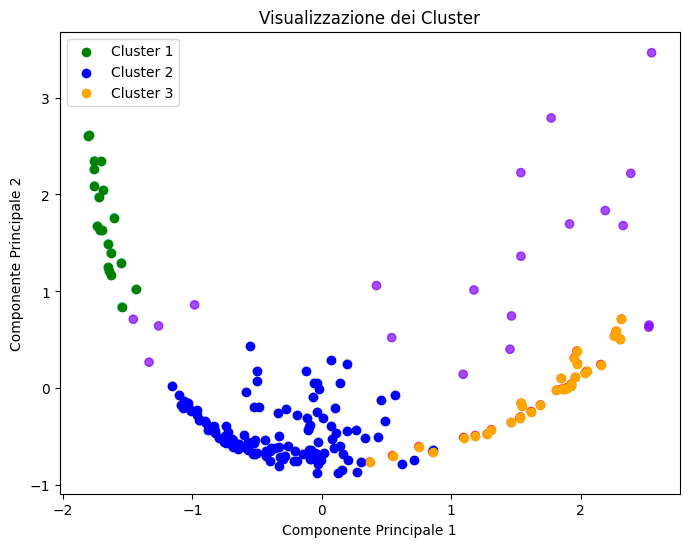

In [14]:
# Riduzione delle dimensioni con PCA a 2 componenti principali
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(cosine_matrix)

# Traccia i cluster con colori specifici
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='rainbow', marker='o', alpha=0.7)
plt.scatter(reduced_features[clusters == 0, 0], reduced_features[clusters == 0, 1], color='green', marker='o', label='Cluster 1')
plt.scatter(reduced_features[clusters == 1, 0], reduced_features[clusters == 1, 1], color='blue', marker='o', label='Cluster 2')
plt.scatter(reduced_features[clusters == 2, 0], reduced_features[clusters == 2, 1], color='orange', marker='o', label='Cluster 3')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.title('Visualizzazione dei Cluster')
plt.legend()
plt.show()

- The X-axis represents the first principal component (PC1) obtained from PCA. This component represents the direction along which the data varies the most.

- The Y-axis represents the second principal component (PC2) obtained from PCA. This component is orthogonal to the first and represents the second direction of maximum variation.

Each point is positioned based on the values ​​of their principal components (PC1 and PC2) after dimension reduction.

Cluster 1 :
Number of observations in cluster: 20
Cluster color: green
------------------------
Cluster 2 :
Number of observations in cluster: 127
Cluster color: blue
------------------------
Cluster 3 :
Number of observations in cluster: 33
Cluster color: orange
------------------------


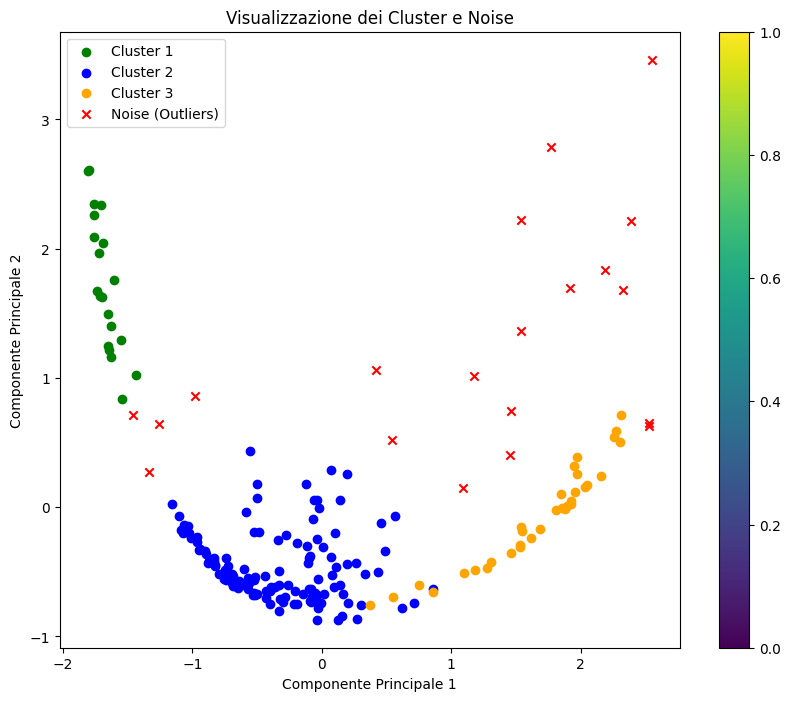

In [13]:
# Confronto tra etichette dei cluster e colori nel grafico
plt.figure(figsize=(10, 8))

for i in range(n_clusters2):
    cluster_points = reduced_features[clusters == i]
    
    if i == 0:
        cluster_color = 'green'
    elif i == 1:
        cluster_color = 'blue'
    elif i == 2:
        cluster_color = 'orange'
    else:
        cluster_color = colormaps.get_cmap('rainbow')(i / n_clusters)
    
    print('Cluster', i+1, ':')
    print('Number of observations in cluster:', len(cluster_points))
    print('Cluster color:', cluster_color)
    print('------------------------')
    
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cluster_color, label=f'Cluster {i+1}')

# Punti noise (outliers)
noise_points = reduced_features[clusters == -1]
plt.scatter(noise_points[:, 0], noise_points[:, 1], color='red', marker='x', label='Noise (Outliers)')

plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.title('Visualizzazione dei Cluster e Noise')
plt.legend()
plt.colorbar()
plt.show()

The red x's that do not form a connected region are actually outliers.

### Explained Variance

Let's look at the variance explained by the first two principal components. This will give you an idea of ​​how well the two components capture the variation in the original data.

These values ​​are important because they give you an idea of ​​how well the first two principal components summarize the information in the original data.

In [15]:
explained_variance = pca.explained_variance_ratio_
print(f"Varianza spiegata dalla componente principale 1: {explained_variance[0]*100:.2f}%")
print(f"Varianza spiegata dalla componente principale 2: {explained_variance[1]*100:.2f}%")

Varianza spiegata dalla componente principale 1: 53.68%
Varianza spiegata dalla componente principale 2: 31.95%


### Correlation Heatmap

A correlation matrix is ​​a statistical tool used to examine the relationship between multiple variables. It helps to identify the features that are related to each other. This is useful to understand if there are redundancies or relationships between the data.

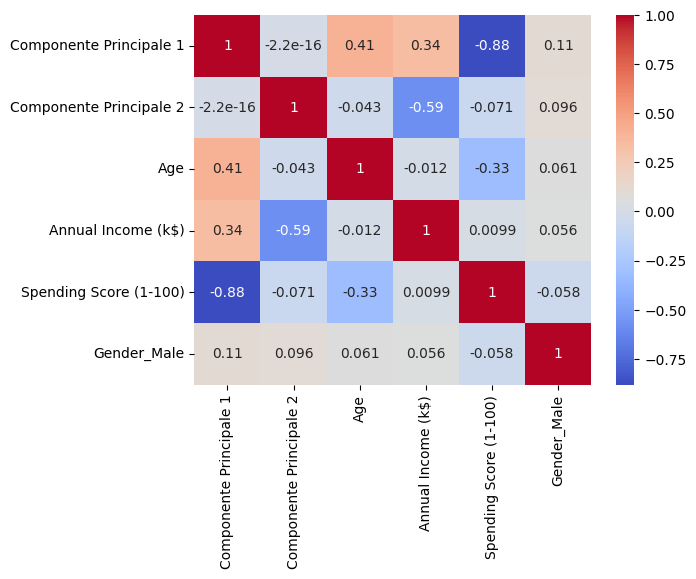

In [16]:
# Creazione di un DataFrame con le componenti principali
pca_df = pd.DataFrame(reduced_features, columns=['Componente Principale 1', 'Componente Principale 2'])

# Encoding one-hot della colonna 'Gender'
df_encoded = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# Combinazione dei DataFrame
pca_df = pd.concat([pca_df, df_encoded], axis=1)

# Rimozione della colonna 'CustomerID'
if 'CustomerID' in pca_df.columns:
    pca_df.drop(columns=['CustomerID'], inplace=True)

# Calcola la matrice di correlazione e genera la heatmap
correlation_matrix = pca_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


The correlation heatmap we generated shows the relationships between the different variables in your dataset after applying PCA. In the heatmap, the colors indicate the degree of correlation between the different variables:

- **Positive Correlation**: Variables that are strongly positively correlated have a color closer to red. This means that when one variable increases, the other tends to increase as well.

- **Negative Correlation**: Variables that are strongly negatively correlated have a color closer to blue. This means that when one variable increases, the other tends to decrease.

- **Neutral Correlation**: Variables that are not strongly correlated have a color closer to white or gray, indicating a neutral or very weak correlation.

To interpret the heatmap:

- **Correlation between Principal Components and Original Attributes**: we can see how much the two principal components (Principal Component 1 and Principal Component 2) are correlated with the original attributes. A strong correlation could indicate that the principal components are capturing important information from the original attributes.

- **Correlation between Original Attributes**: we can examine the correlations between the original attributes with each other. For example, you could see if there is a correlation between age and annual income or between annual income and spending score.

### Clusters Properties

In [17]:
# Get cluster labels and number of clusters
labels = model2.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters:', n_clusters)

Number of clusters: 3


In [18]:
# Add cluster labels to dataframe
df['Cluster_Cosine'] = model2.labels_

# Review cluster labels
print(df['Cluster_Cosine'].value_counts())

Cluster_Cosine
 1    127
 2     33
 0     20
-1     20
Name: count, dtype: int64


- Homogeneity Score: This metric measures how much each cluster contains only samples from a single class. A value of 1.0 indicates that each cluster contains only samples from a single class, making the data split consistent with the known truth labels.

- Completeness Score: This metric measures how much all samples from a single class are assigned to the same cluster. A value of 1.0 indicates that all samples from a single class are assigned to the same cluster, maintaining complete information from the known truth labels.

- V-measure Score: This metric is the harmonic mean between homogeneity and completeness. It provides a comprehensive measure of the alignment between clusters and the known truth labels. A value of 1.0 indicates that clusters perfectly match the known truth labels.

- **Silhouette Score**: This metric measures how similar samples within a cluster are to each other versus how dissimilar they are to samples in neighboring clusters. Values ​​can range from -1 to 1, with higher values ​​indicating better separation of clusters.

In [19]:
# Compute cluster metrics
homogeneity2 = metrics.homogeneity_score(df['Cluster_Cosine'], labels)
completeness2 = metrics.completeness_score(df['Cluster_Cosine'], labels)
v_measure2 = metrics.v_measure_score(df['Cluster_Cosine'], labels)
silhouette2 = metrics.silhouette_score(cosine_matrix, labels)

print("Homogeneity: ", homogeneity2)
print("Completeness: ", completeness2)
print("V-measure: ", v_measure2)
print("Silhouette Score: ", silhouette2)

Homogeneity:  1.0
Completeness:  1.0
V-measure:  1.0
Silhouette Score:  0.5107709022017272


### Davies-Bouldin Index

The **Davies-Bouldin Index** measures the "feasibility" of clusters, considering both the average distance between cluster points and the distance between cluster centroids. The lower the value, the better the clusters.

In [20]:
# Calcola la matrice delle distanze
distance_matrix = pairwise_distances(cosine_matrix, metric='euclidean')

# Calcola l'indice di Davies-Bouldin
davies_bouldin_index2 = davies_bouldin_score(cosine_matrix, clusters)

print("Davies-Bouldin Index:", davies_bouldin_index2)

Davies-Bouldin Index: 1.029587653705788


### Calinski-Harabasz Index

The **Calinski-Harabasz** index calculates the ratio of the within-cluster variance to the between-cluster variance. Higher values ​​indicate better clusters.

In [21]:
# Calcola il Calinski-Harabasz Index
calinski_score2 = calinski_harabasz_score(cosine_matrix, clusters)

print("Calinski-Harabasz Index:", calinski_score2)

Calinski-Harabasz Index: 141.33817593239013


## t-SNE

**t-distributed stochastic neighbor embedding (t-SNE)** is a dimensionality reduction algorithm which is widely used as a machine learning tool in many research fields. It is a nonlinear dimensionality reduction technique that is particularly suited to embedding high-dimensional datasets into a two- or three-dimensional space, where they can be visualized as a scatterplot.

This technique is particularly useful for visualizing high-dimensional data so that the relationships between observations are preserved. Again, the points are colored according to the cluster label.

In [22]:
# Riduzione delle dimensioni con t-SNE a 2 componenti principali
tsne = TSNE(n_components=2)
reduced_features_tsne = tsne.fit_transform(cosine_matrix)

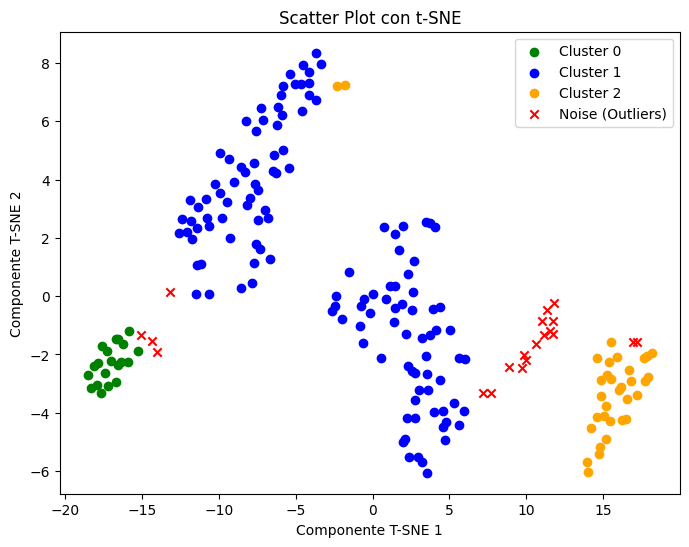

In [23]:
plt.figure(figsize=(8, 6))
for i in range(n_clusters2):
    cluster_points = reduced_features_tsne[clusters == i]
    
    if i == 0:
        cluster_color = 'green'
    elif i == 1:
        cluster_color = 'blue'
    elif i == 2:
        cluster_color = 'orange'
    else:
        cluster_color = 'red'
    
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cluster_color, label=f'Cluster {i}')
    
noise_points_tsne = reduced_features_tsne[clusters == -1]
plt.scatter(noise_points_tsne[:, 0], noise_points_tsne[:, 1], color='red', marker='x', label='Noise (Outliers)')

plt.xlabel('Componente T-SNE 1')
plt.ylabel('Componente T-SNE 2')
plt.title('Scatter Plot con t-SNE')
plt.legend()
plt.show()

### Distance Heatmap

The distance matrix calculated using pairwise_distances is displayed as a heatmap. A heatmap is a graphical representation where different intensities of an attribute are represented by colors. In this case, the colors represent the distance between observations. This can help you identify groups of observations that are closest to each other.

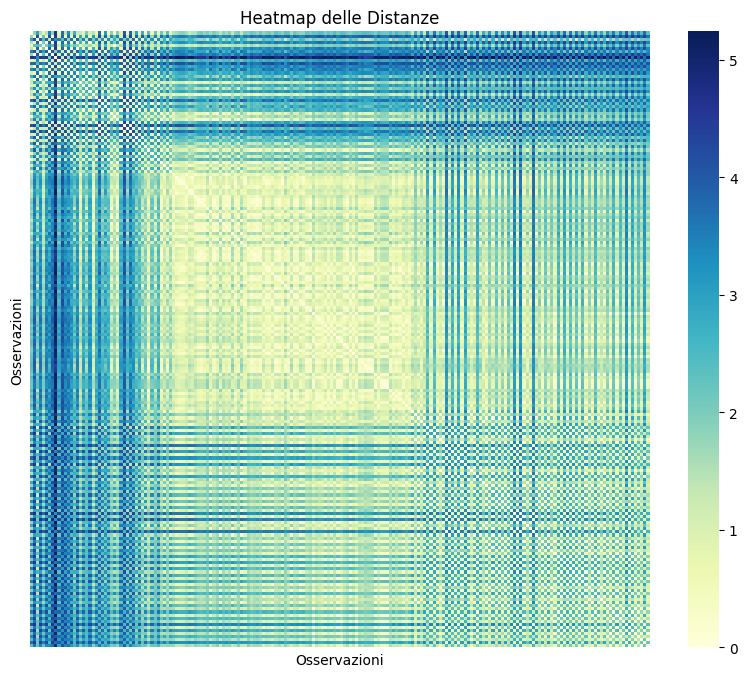

In [24]:
# Calcola la matrice delle distanze
distance_matrix = pairwise_distances(cosine_matrix, metric='euclidean')

# Crea una heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap='YlGnBu', xticklabels=False, yticklabels=False)
plt.title('Heatmap delle Distanze')
plt.xlabel('Osservazioni')
plt.ylabel('Osservazioni')
plt.show()

- The smaller the distance between two observations, the more the corresponding cell will be colored with a color closer to blue or light green.

- The larger the distance between two observations, the more the corresponding cell will be colored with a color closer to red or dark purple.

In essence, the heatmap provides an immediate visualization of the distance relationships between all pairs of observations in the dataset, allowing you to spot patterns of closeness or separation between groups of observations.